In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, recall_score, \
                            classification_report, roc_auc_score, precision_score, \
                            f1_score, matthews_corrcoef, average_precision_score, \
                            precision_recall_curve, auc, roc_curve
from collections import Counter
%config Completer.use_jedi = False

In [2]:
def calc_stats(y_test, y_pred, X_test, clf):
    probs = clf.predict_proba(X_test)
    prob1 = probs[:, 1]
    stats_s = pd.Series(dtype='float')
    stats_s['recall'] = recall_score(y_test, y_pred)
    stats_s['prec'] = precision_score(y_test, y_pred)
    stats_s['MCC'] = matthews_corrcoef(y_test, y_pred)
    precision, recall, _ = precision_recall_curve(y_test, prob1, pos_label=1)
    stats_s['PR_AUC'] = auc(recall, precision)
    stats_s['avg_prec'] = average_precision_score(y_test, prob1)
    stats_s['roc_auc'] = roc_auc_score(y_test, prob1)
    
    return stats_s

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
def sample_data(X, y, samp_type, samp_strat, seed=0):
    if samp_type == 'over':
        sampler = RandomOverSampler(sampling_strategy=samp_strat, random_state=seed)
    elif samp_type == 'under':
        sampler = RandomUnderSampler(sampling_strategy=samp_strat, random_state=seed)
    else:
        print("Invalid 'samp_type'")
        
    # fit and apply the transform
    X_res, y_res = sampler.fit_resample(X, y)
    # summarize class distribution
    #print(Counter(y_res))
    #print(X_res.shape)
    
    return X_res, y_res

# Bootstrapped  random statistics runs

In [4]:
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
def bootstrap_stat(X, y, clf, nsamples=100, sample_weights=False, under=False, samp_strat=1.0):
    stats_df = pd.DataFrame()
    feat_imps_df = pd.DataFrame()
    for seed in range(nsamples):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed)
        #print(f'In bstrap(): y_train.shape = {y_train.shape}; X_train.shape = {X_train.shape}')
        #print(f'In bstrap(): np.bincount(y_train) = {np.bincount(y_train)}')

        if under:
            # Undersample the training data
            #print('Undersampling')
            X_res, y_res = sample_data(X_train, y_train, "under", samp_strat=samp_strat, seed=seed)
        else:
            #print('No Undersampling')
            X_res, y_res = X_train, y_train # Not subsampled; use with class_weight='balanced' or sample_weights
            
        if sample_weights:
            weights = class_weight.compute_sample_weight('balanced', y=y_res)
            #print(f'np.unique(weights): {np.unique(weights)}')
            clf.fit(X_res, y_res, sample_weight=weights)
        else:
            clf.fit(X_res, y_res)
            
        y_pred = clf.predict(X_test)

        stats_s = calc_stats(y_test, y_pred, X_test, clf)
        if stats_df.empty:
            stats_df = pd.DataFrame(stats_s)
            stats_df = stats_df.T
        else:
            stats_df = stats_df.append(stats_s, ignore_index=True)
            
        if feat_imps_df.empty:
            feat_imps_df = pd.DataFrame(data=clf.feature_importances_, index=X_test.columns.values, columns=[seed])
        else:
            temp_df = pd.DataFrame(data=clf.feature_importances_, index=X_test.columns.values, columns=[seed])
            feat_imps_df = feat_imps_df.merge(temp_df, left_index=True, right_index=True, how="left")
        
    return stats_df, feat_imps_df, X_res

In [5]:
corr_df = pd.read_csv('../../data/csl/CramerTheil/Cramer_PI_Tl_coeff_Union50.csv', index_col=0, header=None, delimiter='\t')
#corr_df = pd.read_csv('../../data/csl/CramerTheil/Cramer_PI_noDelmode.csv', index_col=0, header=None, delimiter='\t')
#corr_df = pd.read_csv('../../data/csl/CramerTheil/Cramer_Pre_Tl_coeff_Union50.csv', index_col=0, header=None, delimiter='\t')
corr_vars = list(corr_df.index.values)
len(corr_vars)
df = pd.read_csv('../../data/csl/CSL_tl_PI.csv', index_col=0)
#df = pd.read_csv('../../data/csl/CSL_tl_PI_Freq.csv', index_col=0)
#df = pd.read_csv('../../data/csl/CSL_tl_Pre.csv', index_col=0)
X = df.drop('trans_loss', axis=1, inplace=False)
X = X[corr_vars]
y = df['trans_loss'].values

In [6]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
                                     min_samples_split=900,max_leaf_nodes=None,max_features=12,subsample=0.9,
                                     learning_rate=0.1,random_state=7)
#clf = GradientBoostingClassifier(n_estimators=70, criterion="friedman_mse",max_depth=11, min_samples_leaf=50,
#                                     min_samples_split=900,max_leaf_nodes=None,max_features=None,subsample=0.9,
#                                     learning_rate=0.1,random_state=7)
#stats_df = bootstrap_stat(X, y, clf, nsamples=100, under=True)
stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, nsamples=5, under=True)
#stats_df, feats_df, X_train = bootstrap_stat(X, y, clf, sample_weights=True, nsamples=10, under=False)
stats_df.loc['mean'] = stats_df.mean()
stats_df.loc['mean',:]

CPU times: user 10.3 s, sys: 134 ms, total: 10.5 s
Wall time: 10.5 s


recall      0.881921
prec        0.135190
MCC         0.261697
PR_AUC      0.208523
avg_prec    0.208832
roc_auc     0.833819
Name: mean, dtype: float64

In [7]:
feats_df['mean'] = feats_df.mean(axis=1)
feats_df.sort_values(by='mean', inplace=True, ascending=False)
feats_df.head(20)

,0,1,2,3,4,mean
Delmode,0.210295,0.247370,0.238563,0.240012,0.270936,0.241435
Inoxy_incrdose,0.065815,0.060375,0.097570,0.109158,0.083446,0.083273
Intratocolytix,0.060062,0.067275,0.076105,0.038851,0.067885,0.062036
DMControl,0.053555,0.032987,0.021429,0.024046,0.054583,0.037320
GAmethod,0.036443,0.021462,0.030670,0.023587,0.049090,0.032250
Insurance,0.037202,0.027860,0.030513,0.032305,0.022781,0.030132
ROMmeth,0.031776,0.030824,0.028500,0.033941,0.017896,0.028587
Education,0.033805,0.026341,0.023657,0.031921,0.019228,0.026990
TrialLabor,0.021259,0.032573,0.029964,0.028945,0.020362,0.026621
Analgesia,0.020569,0.027601,0.037348,0.024618,0.019217,0.025870


In [8]:
%%time
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

CPU times: user 9.06 s, sys: 44.4 ms, total: 9.1 s
Wall time: 9 s


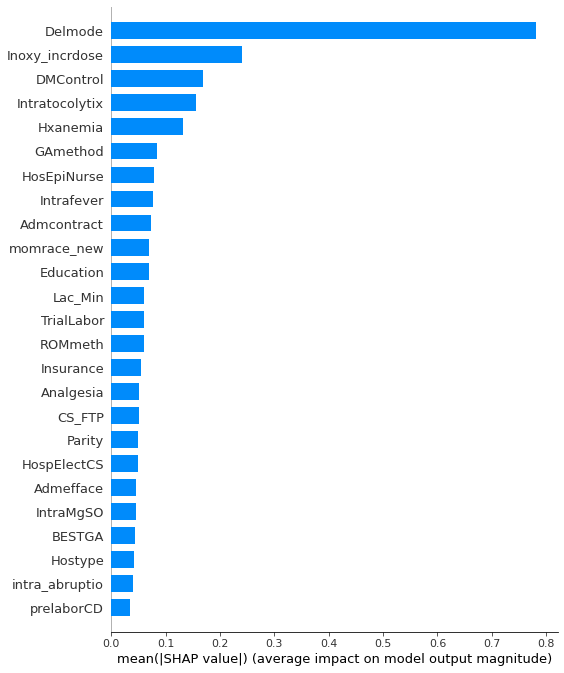

In [9]:
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=25)

          Variable  SHAP_abs      Corr  Sign
25       Admefface  0.046493 -0.812730  blue
31     HospElectCS  0.048757  0.560920   red
60          Parity  0.049117  0.753912   red
15          CS_FTP  0.050431  0.956615   red
10       Analgesia  0.051078 -0.351396  blue
5        Insurance  0.054265 -0.873021  blue
2          ROMmeth  0.059438 -0.621097  blue
3       TrialLabor  0.059618 -0.919648  blue
13         Lac_Min  0.060872 -0.885029  blue
20       Education  0.068694 -0.780826  blue
41     momrace_new  0.069255 -0.576521  blue
7      Admcontract  0.073937 -0.680335  blue
47      Intrafever  0.077662  0.973781   red
17     HosEpiNurse  0.078274 -0.933046  blue
23        GAmethod  0.083744  0.816910   red
28        Hxanemia  0.132344  0.964903   red
22  Intratocolytix  0.156081 -0.795755  blue
18       DMControl  0.168673 -0.516553  blue
4   Inoxy_incrdose  0.240051  0.628071   red
0          Delmode  0.781861  0.922879   red


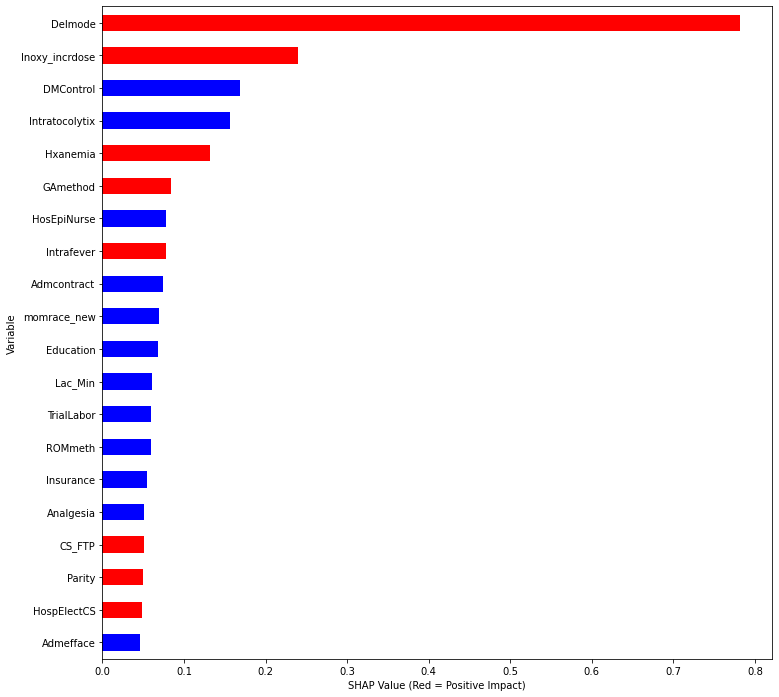

In [68]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2.iloc[46:66,:]['Sign']
    print(k2.iloc[46:66,:])
    ax = k2.iloc[46:66,:].plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(12,12),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values,X_train)

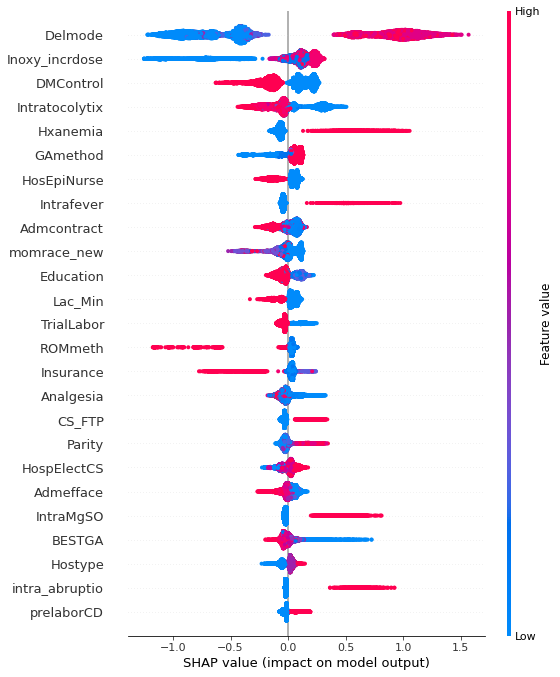

CPU times: user 2.85 s, sys: 17.8 ms, total: 2.87 s
Wall time: 2.86 s


In [69]:
%%time
shap.summary_plot(shap_values, X_train, max_display=25)

In [70]:
shap.initjs()
print(X_train.shape)

(14482, 66)


In [71]:
#shap.plots.scatter(shap_values['Lac_Min'])
shap_values

array([[-0.44502991,  0.01096491,  0.02890165, ...,  0.00206232,
         0.01395127,  0.00780315],
       [ 1.14388903,  0.01585074,  0.04716606, ...,  0.00228069,
        -0.01358367,  0.00428757],
       [ 0.883296  ,  0.00834774,  0.03540185, ...,  0.00451935,
        -0.00764729,  0.02081698],
       ...,
       [ 1.08517394,  0.01410343,  0.05044681, ...,  0.00267092,
        -0.00989925,  0.00693237],
       [ 1.28261047,  0.01945733,  0.06610288, ..., -0.02472506,
         0.05340264, -0.00858756],
       [ 1.01632208,  0.0206757 ,  0.03601216, ..., -0.02727168,
        -0.0064847 , -0.01104557]])

In [72]:
#print(X_train.iloc[500])
#shap.force_plot(explainer.expected_value, shap_values, X_train.iloc[500])
#print(X_train.shape)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


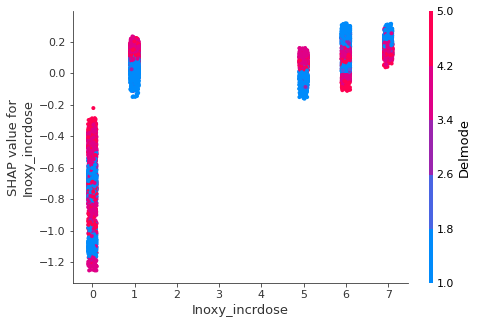

In [73]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


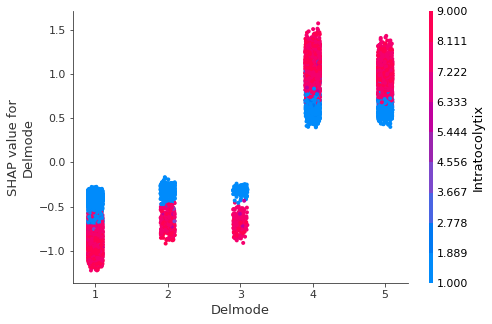

In [74]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


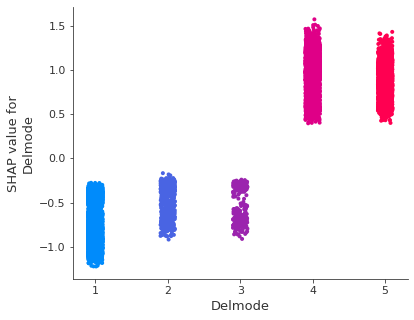

In [75]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.2, interaction_index='Delmode')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


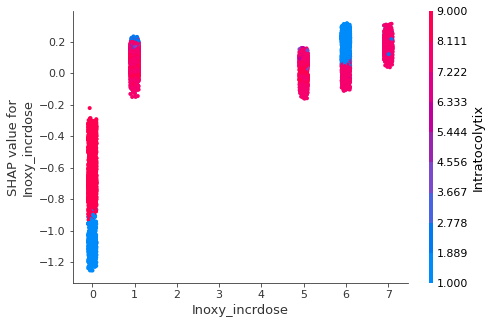

In [76]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Intratocolytix')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


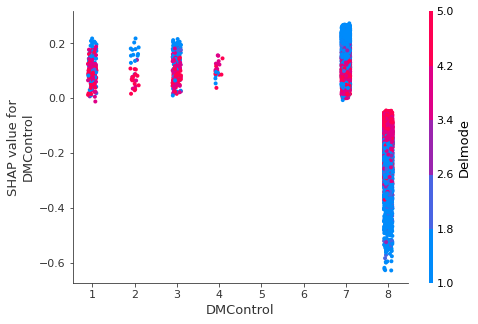

In [77]:
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


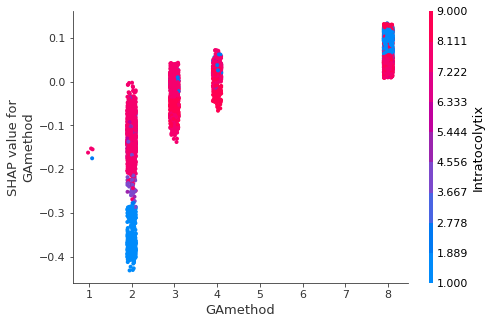

In [78]:
shap.dependence_plot("GAmethod", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


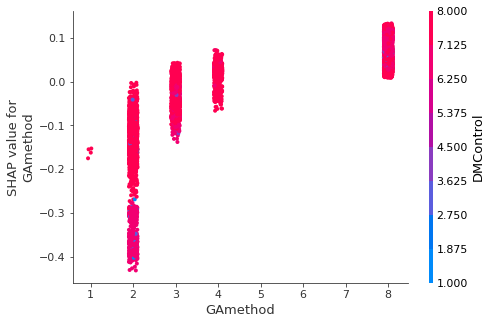

In [79]:
shap.dependence_plot("GAmethod", shap_values, X_train, x_jitter=0.2, interaction_index='DMControl')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


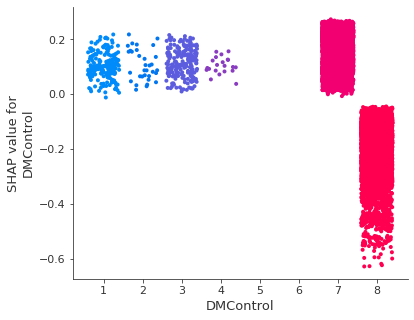

In [80]:
#shap.dependence_plot("DMControl", shap_values, X_train, interaction_index='DMControl')
#shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2, interaction_index='DMControl')
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.8, interaction_index='DMControl')

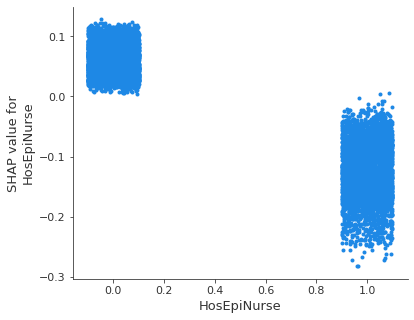

In [81]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2, interaction_index=None)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


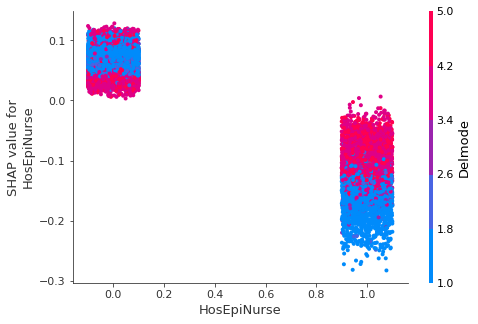

In [82]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


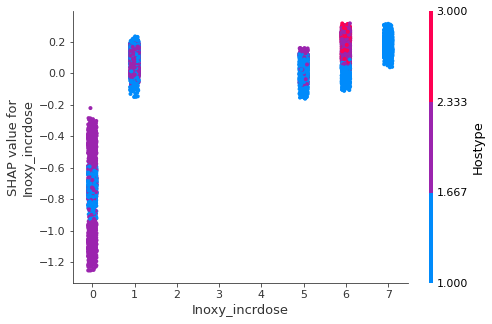

In [83]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Hostype')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


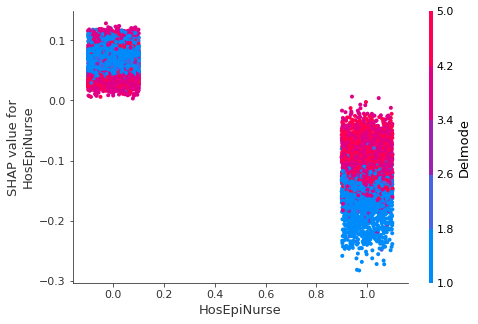

In [84]:
shap.dependence_plot("HosEpiNurse", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


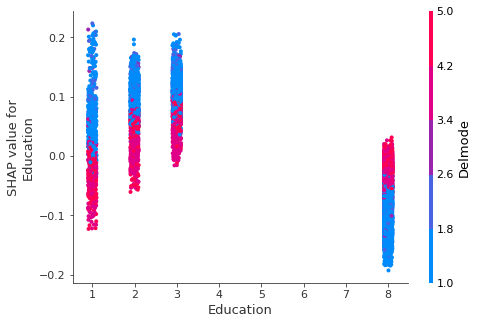

In [85]:
shap.dependence_plot("Education", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


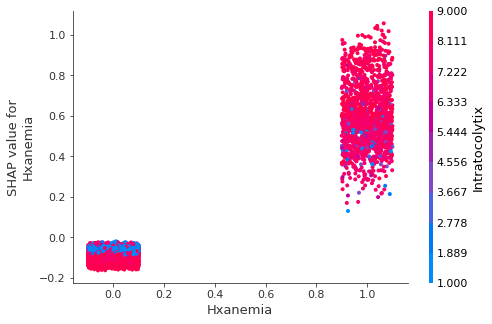

In [86]:
shap.dependence_plot("Hxanemia", shap_values, X_train, x_jitter=0.2)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


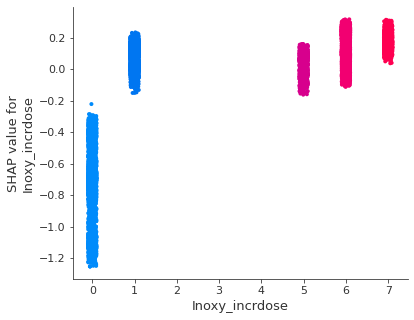

In [87]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Inoxy_incrdose')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


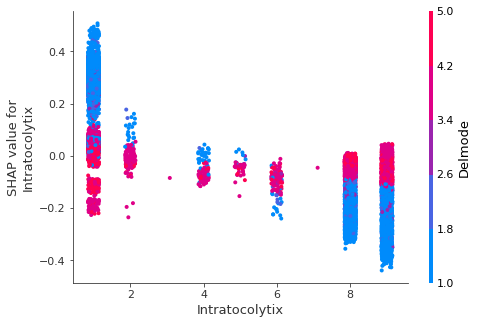

In [97]:
shap.dependence_plot("Intratocolytix", shap_values, X_train, x_jitter=0.3)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


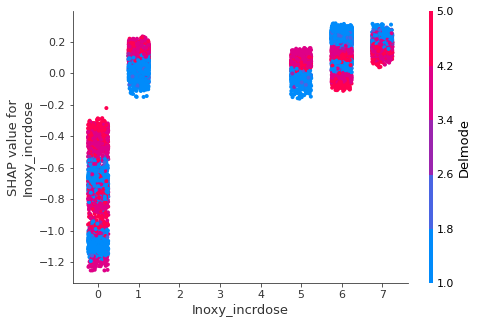

In [109]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.5)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


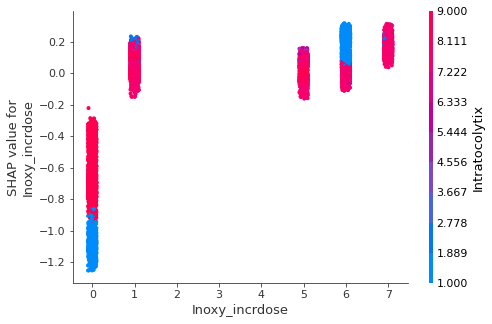

In [105]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index='Intratocolytix')

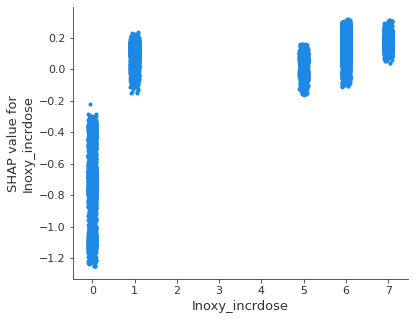

In [90]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.2, interaction_index=None)

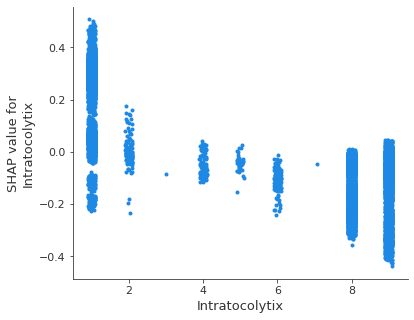

In [91]:
shap.dependence_plot("Intratocolytix", shap_values, X_train, x_jitter=0.2, interaction_index=None)

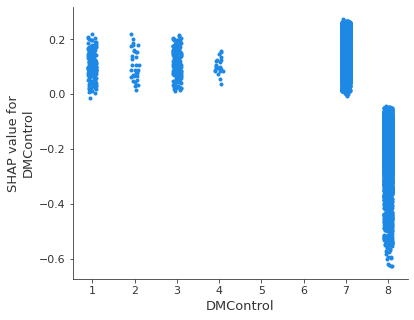

In [92]:
shap.dependence_plot("DMControl", shap_values, X_train, x_jitter=0.2, interaction_index=None)

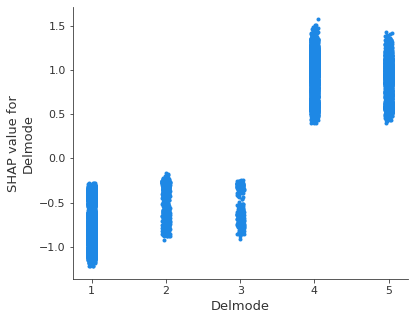

In [93]:
shap.dependence_plot("Delmode", shap_values, X_train, x_jitter=0.1, interaction_index=None)

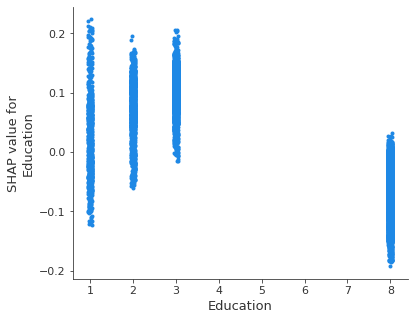

In [94]:
shap.dependence_plot("Education", shap_values, X_train, x_jitter=0.1, interaction_index=None)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


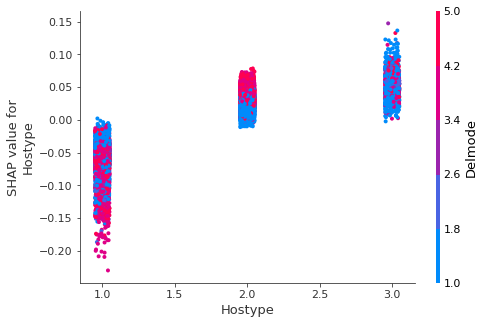

In [98]:
shap.dependence_plot("Hostype", shap_values, X_train, x_jitter=0.1)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


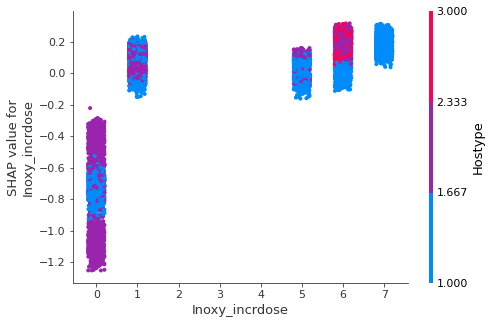

In [110]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Hostype')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


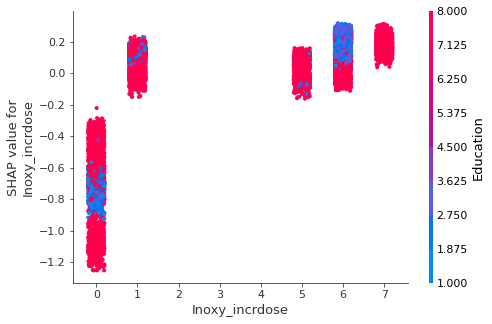

In [111]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Education')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


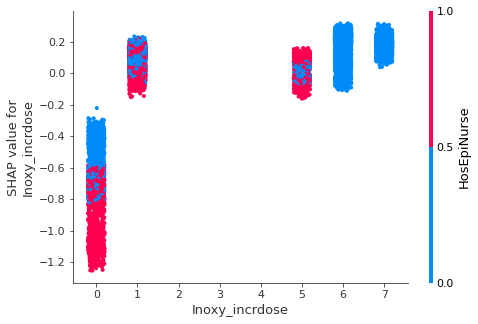

In [112]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='HosEpiNurse')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


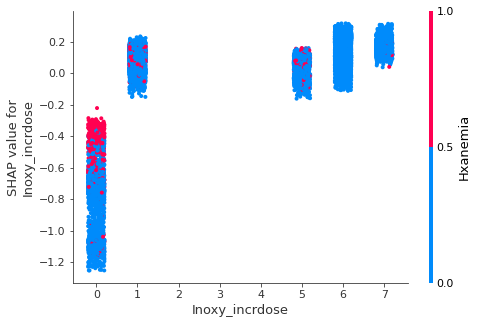

In [113]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Hxanemia')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


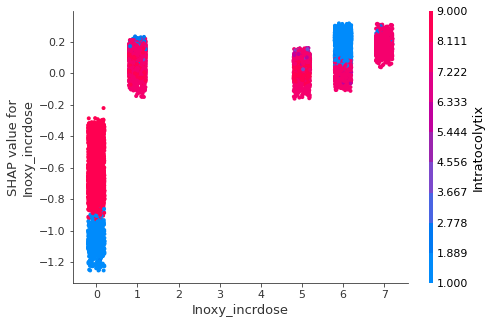

In [114]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='Intratocolytix')

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


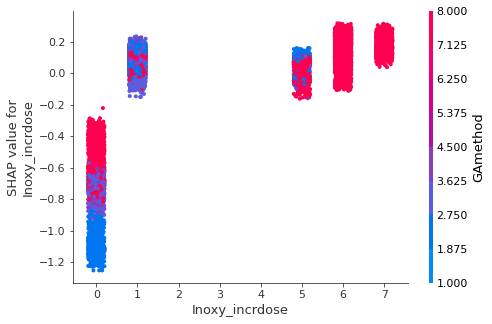

In [116]:
shap.dependence_plot("Inoxy_incrdose", shap_values, X_train, x_jitter=0.4, interaction_index='GAmethod')